<a href="https://colab.research.google.com/github/YuliaVodopyanova/ML_2024/blob/main/%D0%92%D0%BE%D0%B4%D0%BE%D0%BF%D1%8C%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0_%D0%98%D0%90%D0%94_%D0%B8_%D0%B2%D0%B2%D0%B5%D0%B4%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B2_%D0%9C%D0%9E_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D1%8F%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обучение с учителем

1. Выберете из списков один датасет для задачи регресии и один для задачи классификации. Датасеты можно скачать по ссылкам, также архивы есть на гугл-диске.
2. По возможности сопровождайте шаги решения комментариями и графиками\таблицами (напр., матрица ошибок, ROC\PR AUC, validation\training curves, etc.)
3. Задания, отмеченные * или ***, как обычно, опциональны, на 9-10.
4. Обе части ДР будут оцениваться независимо друг от друга, т.е. вы получите 2 оценки.

**Deadline**:  05.05.2024 23:59

# Part 1: Regression

**Choose one dataset**:  

**Base Dataset**: USA Housing https://www.kaggle.com/datasets/aariyan101/usa-housingcsv   
OR   
**Housing Prices Dataset**: https://www.kaggle.com/datasets/yasserh/housing-prices-dataset   
OR   
\*** Advanced Dataset: **The Ames Housing dataset** - https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data, https://www.kaggle.com/datasets/shashanknecrothapa/ames-housing-dataset/data

В задаче регресии необходимо предсказать целевую переменную price.

1. Check if a dataset has missing values, duplicates, outliers, etc. - process them if necessary.
2. Split the data. Apply encoding\normalization\standartization\transformation if necessary.
3. *OPTIONAL Check for multicollinearity if necessary.
4. Thain the model, select better hyperparameters, try applying regularization if necessary.
5. Evaluate model quality on test set (R2, RMSE, etc.).
6. *OPTIONAL Give interpretation to the model coefficients
7. ***OPTIONAL Try more advanced algorithms e.g. XGBoost, etc.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
housing = pd.read_csv('/content/drive/MyDrive/ht2_datasets/Housing.csv')
housing.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
5,10850000,7500,3,3,1,yes,no,yes,no,yes,2,yes,semi-furnished
6,10150000,8580,4,3,4,yes,no,no,no,yes,2,yes,semi-furnished
7,10150000,16200,5,3,2,yes,no,no,no,no,0,no,unfurnished
8,9870000,8100,4,1,2,yes,yes,yes,no,yes,2,yes,furnished
9,9800000,5750,3,2,4,yes,yes,no,no,yes,1,yes,unfurnished




---


**Проверка на наличие пропущенных значений:**

In [ ]:
housing.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

**И на наличие дубликотов:**

In [ ]:
housing.duplicated().sum()

0

Искать **выбросы** можно у столбца price:

<Axes: >

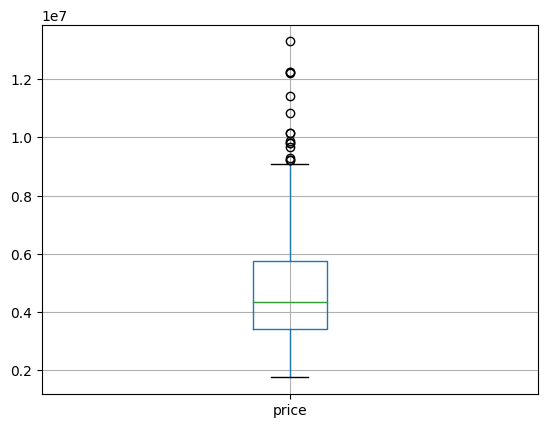

In [ ]:
housing.boxplot(column=['price'])

In [ ]:
Q1 = housing['price'].quantile(0.25)
Q3 = housing['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = housing[(housing['price'] < lower_bound) | (housing['price'] > upper_bound)]

print(f"Всего строк: {len(housing)}\nВыбросов: {len(outliers)}")

Всего строк: 545
Выбросов: 15


Так, в данных нет дубликатов и пропущенных значений, однако в ценах есть выбросы, расположенные выше наблюдаемого максимума.

Я не уверена, что стоит их обрабатывать, поскольку их не так много, а на высокую цену могут влиять другие факторы, как количество комнат, расположение и т.д.

-

В итоге я попробовала и вариант с удалением строк с выбросами, но r2-score понизился до 55-58 процентов у разных моделей (вместе с тем понилизись и средняя абсолютная и средняя квадратичная ошибки, но относительно несильно). Я отдаю предпочтение варианту без удаления строк с выбросами в цене.

In [ ]:
# housing = housing[(housing['price'] >= lower_bound) & (housing['price'] <= upper_bound)]



---


**Кодирование:**

In [ ]:
housing['area'].nunique()

284

In [ ]:
from sklearn.preprocessing import LabelEncoder

columns_to_encode = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

label_encoders = {}
for col in columns_to_encode:
    le = LabelEncoder()
    housing[col] = le.fit_transform(housing[col])
    label_encoders[col] = le

In [ ]:
housing
# ['furnished' 'semi-furnished' 'unfurnished']
# [0 1 2]

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,1,0,1,0,0,2,0,2
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,1
542,1750000,3620,2,1,1,1,0,0,0,0,0,0,2
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split

X = housing.drop('price', axis=1)
y = housing['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)



---


**Проверка на наличие мультиколлинеарности**

In [ ]:
!pip install statsmodels

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

vif = pd.DataFrame()
vif["feature"] = X.columns

vif["VIF"] = [variance_inflation_factor(X_imputed, i) for i in range(X_imputed.shape[1])]
vif

,feature,VIF
0,area,8.270130
1,bedrooms,16.368165
2,bathrooms,9.408363
3,stories,7.880723
4,mainroad,6.852485
5,guestroom,1.472838
6,basement,2.013876
7,hotwaterheating,1.089167
8,airconditioning,1.759717
9,parking,1.985880


собираю воедино все тренировочные данные (и параметры, и целевую переменную) для проверки c помощью корреляции:

In [ ]:
all_train_data = pd.concat([X_train, y_train], axis=1)
all_train_data

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,price
505,4000,3,1,2,1,0,0,0,1,0,0,2,2653000
238,4510,4,2,2,1,0,1,0,0,0,0,1,4613000
246,3520,3,1,1,1,0,0,0,0,0,1,1,4550000
2,9960,3,2,2,1,0,1,0,0,2,1,1,12250000
307,4080,3,1,2,1,0,0,0,0,2,0,1,4165000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,3300,3,3,2,1,0,1,0,0,0,0,1,5530000
528,3970,1,1,1,0,0,0,0,0,0,0,2,2275000
74,4040,3,1,2,1,0,1,1,0,1,0,0,6650000
176,8520,3,1,1,1,0,0,0,1,2,0,0,5250000


In [ ]:
correlation_matrix = all_train_data.corr()
correlation_matrix

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,price
area,1.000000,0.160808,0.173243,0.103921,0.275410,0.154369,0.078283,-0.022779,0.250365,0.393660,0.251704,-0.211269,0.535415
bedrooms,0.160808,1.000000,0.396031,0.400684,-0.001812,0.094924,0.122878,0.066143,0.126253,0.130058,0.098738,-0.142808,0.367061
bathrooms,0.173243,0.396031,1.000000,0.321015,0.053593,0.117569,0.106064,0.066662,0.167120,0.163758,0.088827,-0.171354,0.503653
stories,0.103921,0.400684,0.321015,1.000000,0.114146,0.043478,-0.152159,0.052261,0.248648,0.057296,0.044518,-0.141127,0.410765
mainroad,0.275410,-0.001812,0.053593,0.114146,1.000000,0.109514,0.041563,-0.032792,0.100295,0.207428,0.197757,-0.164199,0.303306
guestroom,0.154369,0.094924,0.117569,0.043478,0.109514,1.000000,0.380404,-0.053441,0.170046,0.072017,0.178752,-0.121260,0.271884
basement,0.078283,0.122878,0.106064,-0.152159,0.041563,0.380404,1.000000,-0.005068,0.054306,0.058293,0.253600,-0.084946,0.218251
hotwaterheating,-0.022779,0.066143,0.066662,0.052261,-0.032792,-0.053441,-0.005068,1.000000,-0.128337,0.073071,-0.052577,-0.048739,0.117543
airconditioning,0.250365,0.126253,0.167120,0.248648,0.100295,0.170046,0.054306,-0.128337,1.000000,0.180348,0.137752,-0.159271,0.445184
parking,0.393660,0.130058,0.163758,0.057296,0.207428,0.072017,0.058293,0.073071,0.180348,1.000000,0.114546,-0.195618,0.428263


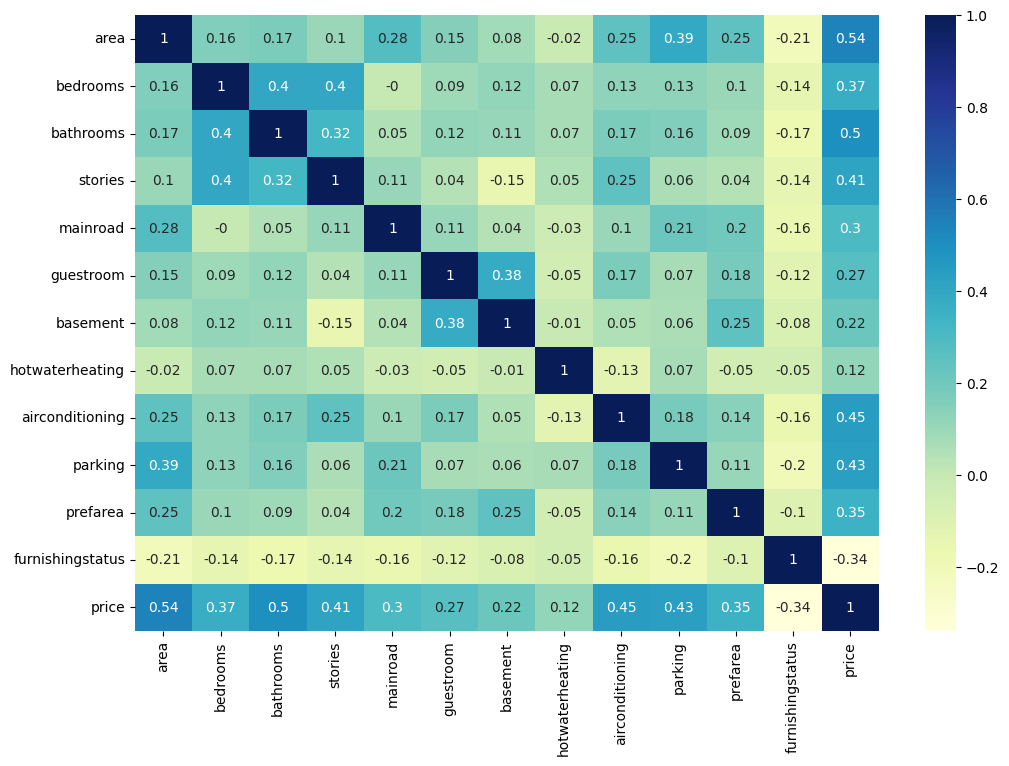

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
plot = sns.heatmap(all_train_data.corr().round(2), cmap="YlGnBu", annot=True)

plt.show()

Высоких корреляций не обнаружено, все в порядке. Уже на этом этапе можно рассмотреть некоторые моменты, то есть то, с чем коррелирует в тренировочных данных цена.

Но сильная коллинеарность наблюдается у количества спален. Из-за этого я подумала убрать столбец, что было сделано строками ниже, но качество модели оказалось лучше с оставлением столбца, поэтому результаты, выведенные сейчас - с использованием столбца bedrooms

In [ ]:
# housing_1 = housing.drop('bedrooms', axis=1)

In [ ]:
# X = housing_1.drop('price', axis=1)
# y = housing_1['price']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

Применяем **стандартизацию** к части данным, содержащим параметры целевой переменной (в результате, я ее не оставила)

In [ ]:
# я пробовала стандартизировать данные (варианты в ячейках ниже),
# просто подставляя новополученные переменные на места
# X_train и X_test, однако при таком раскладе r2-score всех моделей только снижался.
# Такое проделывала для данных и с выбросами цены, и без них (удаляя их из дф ранее), но лучший вариант получился
# без стандартизации и без удаления выбросов, его я и оставила в выводах

In [ ]:
# from sklearn.preprocessing import StandardScaler

# sc = StandardScaler()
# X_train_scaled = sc.fit_transform(X_train)
# X_test_scaled  = sc.fit_transform(X_test)

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# sc = MinMaxScaler()
# X_train_scaled = sc.fit_transform(X_train)
# X_test_scaled  = sc.fit_transform(X_test)



---


**Обучаем модель линейной регрессии**

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model = LinearRegression()

In [ ]:
model.fit(X_train, y_train)

LinearRegression()

Посмотрим на то, как выглядят предсказания для тестовых данных и сами тестовые данные (на примере первых десяти значений цены):

In [ ]:
price_predictions = model.predict(X_test)

compare_lst = []
for i in price_predictions[:10]:
  compare_lst.append(i)
for j in y_test[:10]:
  compare_lst.append(j)

print('[predicted, actual]\n')
for i in range(10):
  print(compare_lst[i::10])

[predicted, actual]

[8187317.322966269, 13300000]
[5722054.437593797, 5950000]
[4896906.1676438395, 4900000]
[4460232.228697581, 4025000]
[6548954.305556884, 6755000]
[4808883.277371395, 4935000]
[4271763.359447595, 3150000]
[2935772.500371788, 2100000]
[3389819.7894779104, 2730000]
[2892468.794670446, 1960000]


In [ ]:
print(f"Model Score: {round(model.score(X_test, y_test) * 100, 2)}%")

Model Score: 64.57%




---


Попробую найти наиболее подходящие гиперпараметры с помощью GridSearchCV для модели Ridge и также ее обучить.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

all_regr_models = []
all_regr_models.append(model)


parameter = {'alpha': [0.1, 1, 10, 25, 30, 100]}
ridge = Ridge()
grid_search = GridSearchCV(ridge, parameter)
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['alpha']
print('Best parameter:', best_alpha)

ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train, y_train)
print(f"Ridge Model Score: {round(ridge_model.score(X_test, y_test) * 100, 2)}%")

all_regr_models.append(ridge_model)

Best parameter: 1
Ridge Model Score: 64.68%


In [ ]:
# price_predictions_ridge = ridge_model.predict(X_test)



---


И для Lasso:

In [ ]:
from sklearn.linear_model import Lasso


param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

lasso = Lasso()

grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=3)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print('Best parameter:', best_params)

lasso_best = Lasso(alpha=best_params['alpha'])
lasso_best.fit(X_train, y_train)
print(f"Ridge Model Score: {round(lasso_best.score(X_test, y_test) * 100, 2)}%")
all_regr_models.append(lasso_best)

Best parameter: {'alpha': 0.001}
Ridge Model Score: 64.57%


In [ ]:
# price_predictions_lasso = lasso_best.predict(X_test)



---


И то же самое для ElasticNet:

In [ ]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet()
elastic_net_param_grid = {
    'alpha': [0.1, 1, 10, 100], 'l1_ratio': [0.1, 0.5, 0.7, 0.8, 0.9]
    }

elastic_net_grid_search = GridSearchCV(elastic_net, elastic_net_param_grid, cv=5)
elastic_net_grid_search.fit(X_train, y_train)

print("Best parameters: ", elastic_net_grid_search.best_params_)
best_alpha_en = elastic_net_grid_search.best_params_['alpha']
best_l1_ratio_en = elastic_net_grid_search.best_params_['l1_ratio']

elastic_net = ElasticNet(alpha=best_alpha_en, l1_ratio=best_l1_ratio_en)
elastic_net.fit(X_train, y_train)
elastic_net_predictions = elastic_net.predict(X_test)

print(f"Model Score: {round(elastic_net.score(X_test, y_test) * 100, 2)}%")

all_regr_models.append(elastic_net)

Best parameters:  {'alpha': 0.1, 'l1_ratio': 0.9}
Model Score: 64.94%




---


**Оценка качества моделей**

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

for model in all_regr_models:
  print(model)
  print(f'\nQuality using R2: {r2_score(y_test, model.predict(X_test)).round(3)}') #по сути и есть то, что у меня было обозначено как model score
  print(f'RMSE: {mean_squared_error(y_test, model.predict(X_test)).round(3)}')
  print(f'MAE: {mean_absolute_error(y_test, model.predict(X_test)).round(3)}\n\n')

LinearRegression()

Quality using R2: 0.646
RMSE: 1251523232072.214
MAE: 816963.353


Ridge(alpha=1)

Quality using R2: 0.647
RMSE: 1247641752977.0
MAE: 814826.266


Lasso(alpha=0.001)

Quality using R2: 0.646
RMSE: 1251523229286.185
MAE: 816963.352


ElasticNet(alpha=0.1, l1_ratio=0.9)

Quality using R2: 0.649
RMSE: 1238603603785.916
MAE: 808789.014




таким образом, модели работают примерно одинаково, имеея средний успех в объяснении вариации целевой переменной (R2 примерно 0.65), однако, высокие значения среднеквадратической ошибки (RMSE) и средней абсолютной ошибки (МАЕ) указывают на значительное отклонение предсказанных значений от фактических.

Наилучшей из использованных (конечно, только слегка лучше) является ElasticNet с подбором гиперпараметров с помощью GridSearch.



---


**Анализ коэффициентов модели** (сделано на основе ElasticNet-модели, которая чуть лучше себя показала)

In [ ]:
coef = elastic_net.coef_
intercept = elastic_net.intercept_

features = ['area',	'bedrooms',	'bathrooms',	'stories',	'mainroad',	'guestroom',\
            'basement','hotwaterheating','airconditioning','parking','prefarea','furnishingstatus']

features_for_df = {}
print('Intercept (Bias):', intercept)
print('Feature Coefficients:')
for ind, coef in enumerate(coef):
  print(f"Feature '{features[ind]}': {coef}")
  features_for_df[features[ind]] = abs(coef) #чтобы далее отсортировать, нужен модуль, поскольку furnishingstatus у нас будет отрицательным

Intercept (Bias): 196389.20191585738
Feature Coefficients:
Feature 'area': 233.16479974085124
Feature 'bedrooms': 123789.27403738725
Feature 'bathrooms': 924477.0514135408
Feature 'stories': 441431.6591773151
Feature 'mainroad': 462039.01952843426
Feature 'guestroom': 292418.6625866813
Feature 'basement': 407635.6220542399
Feature 'hotwaterheating': 830267.5774867227
Feature 'airconditioning': 800365.0179682885
Feature 'parking': 358314.7503921835
Feature 'prefarea': 584649.8468844512
Feature 'furnishingstatus': -221751.56158116047


In [ ]:
features_data = {'Feature': list(features_for_df.keys()), 'Coefficient': list(features_for_df.values())}
coefficients_df = pd.DataFrame(features_data)

sorted_coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

sorted_coefficients_df

,Feature,Coefficient
2,bathrooms,924477.051414
7,hotwaterheating,830267.577487
8,airconditioning,800365.017968
10,prefarea,584649.846884
4,mainroad,462039.019528
3,stories,441431.659177
6,basement,407635.622054
9,parking,358314.750392
5,guestroom,292418.662587
11,furnishingstatus,221751.561581


Из выводов выше можно понять, какие признаки в наибольшей степени влияют на целевую переменную (расположены по убыванию). Так, в большей степени значимо количество ванных комнат; а меньшее влияние на цену из данных признаков оказывает географическое расположение. (насколько я понимаю, эти коэффициенты необязательно обозначают низкую/высокую корреляцию, а просто означают некоторые веса, с которыми признак влияет на целевую переменную)

Что касается данного вывода: Intercept (Bias): 159231.37350725103 - он демонстрирует базовый уровень целевой переменной, когда все признаки равны нулю, то есть, по сути, когда все признаки не влияют на предсказание, цена жилья составляет указанное число.



---


**XGBRegressor** я также попробовала применить, его оценка оказалась повыше, чем у предыдущих моделей, ошибки поменьше, но все равно большие:

In [ ]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor()

param_grid = {
  'n_estimators': [200, 300, 350],
  'learning_rate': [0.01, 0.1, 0.2],
  'max_depth': [1, 2, 3, 4, 5]
}

grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print('Best parameters:', best_params)

price_predictions_xgb = best_model.predict(X_test)

print(f'Quality using R2: {r2_score(y_test, price_predictions_xgb).round(3)}')
print(f'MSE: {mean_squared_error(y_test, price_predictions_xgb).round(3)}')
print(f'MAE: {mean_absolute_error(y_test, price_predictions_xgb).round(3)}')

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 350}
Quality using R2: 0.662
MSE: 1192572083038.996
MAE: 788266.998


In [ ]:
compare_lst = []
for i in price_predictions_xgb[:10]:
  compare_lst.append(i)
for j in y_test[:10]:
  compare_lst.append(j)

print('[predicted, actual]\n')
for i in range(10):
  print(compare_lst[i::10])

[predicted, actual]

[8667853.0, 13300000]
[5854669.0, 5950000]
[4873632.5, 4900000]
[4325910.5, 4025000]
[6970631.5, 6755000]
[4941303.5, 4935000]
[4112719.5, 3150000]
[2840379.5, 2100000]
[3496206.5, 2730000]
[2708804.8, 1960000]


эти предсказания я просто визуально сравнила с предсказаниями первой модели, по крайней мере эти десять правда стали поточнее

**Вывод**

Все модели работают с примерно одинаковыми оценками и ошибками, но лучше остальных стала XGBRegressor по всем рассмотренным критериям.

Также результаты оказались лучше без удаления выьросов в цене, без стандартизации и без удаления колонки 'bedrooms', где была обнаружена довольно высокая коллениарность. Может, я что-то сделала не так, но пыталась комбинировать эти варинты между собой - лучше исходного варианта не получила.

# Part 2: Classification

**Choose one dataset**:  
Mushroom Classification: https://www.kaggle.com/datasets/uciml/mushroom-classification   
OR   
Credit Risk:https://www.kaggle.com/datasets/praveengovi/credit-risk-classification-dataset   
OR   
Lung_cancer: https://www.kaggle.com/datasets/nancyalaswad90/lung-cancer   
OR   
*** Toxic Comment Classification: https://www.kaggle.com/datasets/julian3833/jigsaw-toxic-comment-classification-challenge?select=train.csv

1. Check if a dataset has missing values, duplicates, outliers, etc. - process them if necessary.
2. Split the data. Apply encoding\normalization\standartization if necessary.
3. Thain the model, select better hyperparameters.
4. Evaluate model quality on test set.
5. *OPTIONAL Train several models based on various algorithms, compare training\inference time, prediction quality, interpretability of the results (if applicable).
6. *OPTIONAL Apply feature selection\engineering if possible.
7. ***OPTIONAL Try more advanced algorithms including XGBoost, CatBoost, etc.

In [ ]:
mushrooms = pd.read_csv('/content/drive/MyDrive/ht2_datasets/mushrooms.csv')
mushrooms

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l




---


**Проверка на наличие пропущенных значений и дубликатов**

In [ ]:
mushrooms.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [ ]:
mushrooms.duplicated().sum()

0

In [ ]:
for col in mushrooms:
  print(col.ljust(25), mushrooms[col].unique())

class                     ['p' 'e']
cap-shape                 ['x' 'b' 's' 'f' 'k' 'c']
cap-surface               ['s' 'y' 'f' 'g']
cap-color                 ['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
bruises                   ['t' 'f']
odor                      ['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
gill-attachment           ['f' 'a']
gill-spacing              ['c' 'w']
gill-size                 ['n' 'b']
gill-color                ['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
stalk-shape               ['e' 't']
stalk-root                ['e' 'c' 'b' 'r' '?']
stalk-surface-above-ring  ['s' 'f' 'k' 'y']
stalk-surface-below-ring  ['s' 'f' 'y' 'k']
stalk-color-above-ring    ['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
stalk-color-below-ring    ['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
veil-type                 ['p']
veil-color                ['w' 'n' 'o' 'y']
ring-number               ['o' 't' 'n']
ring-type                 ['p' 'e' 'l' 'f' 'n']
spore-print-color         ['k' 'n' 'u' 'h' 'w' 'r' '

Как видно, дубликатов, пропущенных значений нет, а также в колонках присутствует ограниченное количество значений, среди которых выбросы искать мне кажется нерационально, это просто некоторые категории


---



In [ ]:
from sklearn.preprocessing import OneHotEncoder #, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import time

Разделим данные на features и target, закодируем переменные в Х, разделим данные на 4 выборки и обучим разные модели

In [ ]:
X = mushrooms.drop('class', axis=1)
y = mushrooms['class']

In [ ]:
categorical_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)]
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
!pip install catboost

In [ ]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier


models = {
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Random Forest Classifier': RandomForestClassifier(),
    'CatBoost Classifier': CatBoostClassifier(verbose=0)
}


for model_name, model in models.items():
  model_pipeline = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('classifier', model)
  ])

  start_time = time.time()
  model_pipeline.fit(X_train, y_train)
  train_time = time.time() - start_time

  start_time2 = time.time()
  y_pred = model_pipeline.predict(X_test)
  predict_time = time.time() - start_time2

  print(f'Model: {model_name}\n')
  print(classification_report(y_test, y_pred))
  print(f'\nTime to train the model: {train_time}\nTime to predict: {predict_time}\nTotal time: {train_time+predict_time}\n\n')

Model: Decision Tree Classifier

              precision    recall  f1-score   support

           e       1.00      1.00      1.00       843
           p       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625


Time to train the model: 0.0686042308807373
Time to predict: 0.01250910758972168
Total time: 0.08111333847045898


Model: Random Forest Classifier

              precision    recall  f1-score   support

           e       1.00      1.00      1.00       843
           p       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625


Time to train the model: 0.5652713775634766
Time to predict: 0.03978896141052246
Total time: 0.605060338973999


Model: CatBoost Classifier

              precisio

Таким образом, все модели отлично справляются с задачей, но дерево решений демонстрирует наиболее быструю работу.



---


**Дальше посмотрим на работу классификатора XGBClassifier.**

Для него я кодирую числовыми значениями все колонки, на всякий случай сохраняя, какое кодированное значение соответствует какой прежней категории:

In [ ]:
X_encoded = X.copy()
encoding_map = {}

for column in X_encoded.columns:
  le = LabelEncoder()
  encoded_values = le.fit_transform(X_encoded[column])
  X_encoded[column] = encoded_values

  encoding_map[column] = dict(zip(le.classes_, le.transform(le.classes_)))

print('Values before and after encoding:\n')
encoding_map

Values before and after encoding:



{'cap-shape': {'b': 0, 'c': 1, 'f': 2, 'k': 3, 's': 4, 'x': 5},
 'cap-surface': {'f': 0, 'g': 1, 's': 2, 'y': 3},
 'cap-color': {'b': 0,
  'c': 1,
  'e': 2,
  'g': 3,
  'n': 4,
  'p': 5,
  'r': 6,
  'u': 7,
  'w': 8,
  'y': 9},
 'bruises': {'f': 0, 't': 1},
 'odor': {'a': 0,
  'c': 1,
  'f': 2,
  'l': 3,
  'm': 4,
  'n': 5,
  'p': 6,
  's': 7,
  'y': 8},
 'gill-attachment': {'a': 0, 'f': 1},
 'gill-spacing': {'c': 0, 'w': 1},
 'gill-size': {'b': 0, 'n': 1},
 'gill-color': {'b': 0,
  'e': 1,
  'g': 2,
  'h': 3,
  'k': 4,
  'n': 5,
  'o': 6,
  'p': 7,
  'r': 8,
  'u': 9,
  'w': 10,
  'y': 11},
 'stalk-shape': {'e': 0, 't': 1},
 'stalk-root': {'?': 0, 'b': 1, 'c': 2, 'e': 3, 'r': 4},
 'stalk-surface-above-ring': {'f': 0, 'k': 1, 's': 2, 'y': 3},
 'stalk-surface-below-ring': {'f': 0, 'k': 1, 's': 2, 'y': 3},
 'stalk-color-above-ring': {'b': 0,
  'c': 1,
  'e': 2,
  'g': 3,
  'n': 4,
  'o': 5,
  'p': 6,
  'w': 7,
  'y': 8},
 'stalk-color-below-ring': {'b': 0,
  'c': 1,
  'e': 2,
  'g': 3,
 

In [ ]:
X_encoded

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,5,2,4,1,6,1,0,1,4,0,...,2,7,7,0,2,1,4,2,3,5
1,5,2,9,1,0,1,0,0,4,0,...,2,7,7,0,2,1,4,3,2,1
2,0,2,8,1,3,1,0,0,5,0,...,2,7,7,0,2,1,4,3,2,3
3,5,3,8,1,6,1,0,1,5,0,...,2,7,7,0,2,1,4,2,3,5
4,5,2,3,0,5,1,1,0,4,1,...,2,7,7,0,2,1,0,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,3,2,4,0,5,0,0,0,11,0,...,2,5,5,0,1,1,4,0,1,2
8120,5,2,4,0,5,0,0,0,11,0,...,2,5,5,0,0,1,4,0,4,2
8121,2,2,4,0,5,0,0,0,5,0,...,2,5,5,0,1,1,4,0,1,2
8122,3,3,4,0,8,1,0,1,0,1,...,1,7,7,0,2,1,0,7,4,2


In [ ]:
y2 = y.map({'e': 0, 'p': 1})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y2, test_size=0.2, random_state=42)

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.1, 0.01, 0.001]
}

xgb_model = XGBClassifier()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5)

start_time = time.time()
grid_search.fit(X_train, y_train)
train_time = time.time() - start_time

start_time2 = time.time()
y_pred_xgb = grid_search.predict(X_test)
predict_time = time.time() - start_time2

print('XGBClassifier with Grid Search:\n')
print(classification_report(y_test, y_pred_xgb))
print(f'\nTime to train the model: {train_time}\nTime to predict: {predict_time}\nTotal time: {train_time+predict_time}')

XGBClassifier with Grid Search:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       843
           1       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625


Time to train the model: 65.53049445152283
Time to predict: 0.008079290390014648
Total time: 65.53857374191284


Удалось подобрать подходящие параметры для модели XGBClassifier, при которых точность, полнота и f1-score были равны единице, но на ее обучение потратилось больше времени (частично связано с использование GridSearch); зато именно она дает предсказания быстрее всех из расмотренных выше моделей.



---


Изначально я подумала о том, что осуществить **выбор определенных признаков**, используемых для обучения и предсказания, можно только на основе корреляции, что с выбранным датафреймом не получится сделать, но потом подумала о коэффициентах из задания с регрессией. Не уверена, что так делать можно и логично, ведь перед обучением модели приходится создавать еще одну, но я решила попробовать.

In [ ]:
from sklearn.linear_model import LogisticRegression


model_lin = LogisticRegression(max_iter=1000)
model_lin.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
coef = model_lin.coef_
intercept = model_lin.intercept_

features = ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',\
            'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape',\
            'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', \
            'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color',\
            'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']

s = ''
features_for_df = {}
print('Intercept (Bias):', intercept)
print('Feature Coefficients:')
for ind, coef in enumerate(coef.T):
  s += 'Feature ' + features[ind] + ': '
  for coef_val in coef:
    s += str(coef_val)
    print(s)
    s = ''

  features_for_df[features[ind]] = abs(coef_val)

Intercept (Bias): [-2.94238533]
Feature Coefficients:
Feature cap-shape: -0.051276107818800064
Feature cap-surface: 0.448430241791408
Feature cap-color: -0.04254852332315377
Feature bruises: -0.9412887984030414
Feature odor: -0.4915764580204598
Feature gill-attachment: -1.877640898217824
Feature gill-spacing: -6.2968547429460235
Feature gill-size: 7.127268888915585
Feature gill-color: -0.11406933849094436
Feature stalk-shape: 0.040730847097351086
Feature stalk-root: -1.750024760697834
Feature stalk-surface-above-ring: -4.1929776234592815
Feature stalk-surface-below-ring: -0.3111254755264646
Feature stalk-color-above-ring: -0.12740859590505568
Feature stalk-color-below-ring: -0.041036977250512696
Feature veil-type: 0.0
Feature veil-color: 7.4450200918346585
Feature ring-number: 1.0535509612788758
Feature ring-type: 0.867147387032461
Feature spore-print-color: -0.23692258575430022
Feature population: -0.3382780582977697
Feature habitat: 0.11231607786753953


In [ ]:
features_data = {'Feature': list(features_for_df.keys()), 'Coefficient': list(features_for_df.values())}
coefficients_df = pd.DataFrame(features_data)

sorted_coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

sorted_coefficients_df

,Feature,Coefficient
16,veil-color,7.445020
7,gill-size,7.127269
6,gill-spacing,6.296855
11,stalk-surface-above-ring,4.192978
5,gill-attachment,1.877641
10,stalk-root,1.750025
17,ring-number,1.053551
3,bruises,0.941289
18,ring-type,0.867147
4,odor,0.491576


Были выделены признаки, в наибольшей степени влияющие на класс (где значения коэффициентов больше единицы)

In [ ]:
mushrooms_selected = mushrooms[['class', 'veil-color', 'gill-size', 'gill-spacing',\
                               'stalk-surface-above-ring', 'gill-attachment',\
                               'stalk-root', 'ring-number']].copy()

In [ ]:
mushrooms_selected

,class,veil-color,gill-size,gill-spacing,stalk-surface-above-ring,gill-attachment,stalk-root,ring-number
0,p,w,n,c,s,f,e,o
1,e,w,b,c,s,f,c,o
2,e,w,b,c,s,f,c,o
3,p,w,n,c,s,f,e,o
4,e,w,b,w,s,f,e,o
...,...,...,...,...,...,...,...,...
8119,e,o,b,c,s,a,?,o
8120,e,n,b,c,s,a,?,o
8121,e,o,b,c,s,a,?,o
8122,p,w,n,c,s,f,?,o


Затем, как и в предыдущий раз, используется кодирование и тот же DecisionTreeClassifier (быстрый как в обучении, так и в предсказании), здесь также используется подбор параметров с помощью GridSearchCV:

In [ ]:
for column in mushrooms_selected.columns:
  le = LabelEncoder()
  encoded_values = le.fit_transform(mushrooms_selected[column])
  mushrooms_selected[column] = encoded_values

In [ ]:
X = mushrooms_selected.drop('class', axis=1)
y = mushrooms_selected['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

tree_model = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5)

start_time = time.time()
grid_search.fit(X_train, y_train)
train_time = time.time() - start_time

start_time2 = time.time()
y_pred_xgb = grid_search.predict(X_test)
predict_time = time.time() - start_time2

print('DecisionTreeClassifier with Grid Search:\n')
print(classification_report(y_test, y_pred_xgb))
print(f'\nTime to train the model: {train_time}\nTime to predict: {predict_time}\nTotal time: {train_time+predict_time}')

DecisionTreeClassifier with Grid Search:

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       843
           1       0.95      0.94      0.94       782

    accuracy                           0.95      1625
   macro avg       0.95      0.95      0.95      1625
weighted avg       0.95      0.95      0.95      1625


Time to train the model: 3.220468521118164
Time to predict: 0.0030782222747802734
Total time: 3.2235467433929443


В связи с некоторыми отброшенными данными, модель работает не так идеально, как прежде, что логично.

Данная модель использует для обучения и предсказаний только 7 из былых 22 признаков, так что дает вполне себе неплохие показатели. Выбор границы нижней грани для веса признака (который у меня был = 1) можно уменьшить, тогда результаты, конечно, улучшаться.